## debug the transformation problem

```bash
File "/home/r7user3/ZhangHT/github/maskrcnn-benchmark/maskrcnn_benchmark/engine/trainer.py", line 118, in do_train
    for iteration, (images, targets, _) in enumerate(data_loader, start_iter):
  File "/home/r7user3/anaconda2/envs/maskrcnn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 615, in __next__
    batch = self.collate_fn([self.dataset[i] for i in indices])
  File "/home/r7user3/anaconda2/envs/maskrcnn/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 615, in <listcomp>
    batch = self.collate_fn([self.dataset[i] for i in indices])
  File "/home/r7user3/ZhangHT/github/maskrcnn-benchmark/maskrcnn_benchmark/data/datasets/coco.py", line 61, in __getitem__
    img, target = self.transforms(img, target)
  File "/home/r7user3/ZhangHT/github/maskrcnn-benchmark/maskrcnn_benchmark/data/transforms/transforms.py", line 19, in __call__
    image, target = t(image, target)
  File "/home/r7user3/ZhangHT/github/maskrcnn-benchmark/maskrcnn_benchmark/data/transforms/transforms.py", line 95, in __call__
    target=F.rotate(target,angle)
  File "/home/r7user3/anaconda2/envs/maskrcnn/lib/python3.7/site-packages/torchvision/transforms/functional.py", line 593, in rotate
    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
TypeError: img should be PIL Image. Got <class 'maskrcnn_benchmark.structures.bounding_box.BoxList'>

```

### train_net.py

In [91]:
from maskrcnn_benchmark.config import cfg
import os
import torch
from maskrcnn_benchmark.utils.comm import get_world_size
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.solver import make_lr_scheduler
from maskrcnn_benchmark.solver import make_optimizer

In [92]:
def reduce_loss_dict(loss_dict):
    """
    Reduce the loss dictionary from all processes so that process with rank
    0 has the averaged results. Returns a dict with the same fields as
    loss_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return loss_dict
    with torch.no_grad():
        loss_names = []
        all_losses = []
        for k in sorted(loss_dict.keys()):
            loss_names.append(k)
            all_losses.append(loss_dict[k])
        all_losses = torch.stack(all_losses, dim=0)
        dist.reduce(all_losses, dst=0)
        if dist.get_rank() == 0:
            # only main process gets accumulated, so only divide by
            # world_size in this case
            all_losses /= world_size
        reduced_losses = {k: v for k, v in zip(loss_names, all_losses)}
    return reduced_losses


In [5]:
# simulate the true working dir
os.chdir('/home/r7user3/ZhangHT/github/maskrcnn-benchmark/')

In [6]:
cfg.merge_from_file('./configs/e2e_mask_rcnn_R_50_FPN_1x.yaml')
cfg.freeze()

In [7]:
distributed=False
start_iter=0

In [8]:
data_loader = make_data_loader(
        cfg,
        is_train=True,
        is_distributed=distributed,
        start_iter=start_iter,
    )

When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


### trainer.py

This Problem is caused by **too large** learning rate

In [9]:
model=build_detection_model(cfg)
device = torch.device(cfg.MODEL.DEVICE)
device

device(type='cuda')

In [10]:
model.to(device)
optimizer = make_optimizer(cfg, model)
scheduler = make_lr_scheduler(cfg, optimizer)

In [27]:
max_iter = 100
start_iter = 0 # 0 at start

model.train() # begin training

######################################################################################################################
# Note: once begin training, rank of GPU will change iteratively! So the rank of GPU is 0 above this comment.
#       Moreover, iteration is counted following rank 0 GPU. In other words, all checkpoint work on cuda:0.
######################################################################################################################
for iteration, (images, targets,_) in enumerate(data_loader,0):
    

    iteration = iteration + 1
    print('iteration:',iteration)

    scheduler.step()
    print('cp1')

    images = images.to(device)
    targets = [target.to(device) for target in targets]
    print('cp2')
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())

    # reduce losses over all GPUs for logging purposes
    loss_dict_reduced = reduce_loss_dict(loss_dict)
    losses_reduced = sum(loss for loss in loss_dict_reduced.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if iteration % 20 == 0 or iteration == max_iter:
        print('Loss',losses.item())

iteration: 1
cp1


RuntimeError: CUDA error: device-side assert triggered

## multi train

Learning rate is too large, suggest to be 0.0025.
```bash
CUDA_VISIBLE_DEVICES=2,3 python -m torch.distributed.launch --nproc_per_node=2 --master_addr 127.0.0.2 --master_port 29501 tools/train_net.py --config-file configs/e2e_mask_rcnn_R_50_FPN_1x.yaml SOLVER.IMS_PER_BATCH 4 SOLVER.BASE_LR 0.005 SOLVER.MAX_ITER 30000 SOLVER.STEPS "(15000, 20000)" TEST.IMS_PER_BATCH 2
```

```bash
python tools/train_net.py --config-file "configs/e2e_mask_rcnn_R_50_FPN_1x.yaml" SOLVER.BASE_LR 0.0025 SOLVER.MAX_ITER 60000 SOLVER.STEPS "(30000, 40000)" TEST.IMS_PER_BATCH 1
```

```bash
python tools/train_net.py --config-file "configs/e2e_mask_rcnn_R_50_FPN_1x.yaml" SOLVER.BASE_LR 0.0025 SOLVER.IMS_PER_BATCH 2 TEST.IMS_PER_BATCH 1
```

2019/01/15
```bash
CUDA_VISIBLE_DEVICES=2,3 python -m torch.distributed.launch --nproc_per_node=2 --master_addr 127.0.0.2 --master_port 29501 tools/train_net.py --config-file configs/e2e_mask_rcnn_R_50_FPN_1x.yaml SOLVER.BASE_LR 0.0025 SOLVER.IMS_PER_BATCH 4 TEST.IMS_PER_BATCH 2
```

2019/01/16
```bash
CUDA_VISIBLE_DEVICES=2,3 python -m torch.distributed.launch --nproc_per_node=2 --master_addr 127.0.0.2 --master_port 29501 tools/train_net.py --config-file configs/e2e_mask_rcnn_R_50_FPN_1x.yaml SOLVER.BASE_LR 0.0025 SOLVER.IMS_PER_BATCH 8 TEST.IMS_PER_BATCH 4
```

2019/01/17

(Work)
```bash
CUDA_VISIBLE_DEVICES=2,3 python -m torch.distributed.launch --nproc_per_node=2 --master_addr 127.0.0.2 --master_port 29501 tools/train_net.py --config-file configs/e2e_mask_rcnn_R_50_FPN_1x.yaml SOLVER.BASE_LR 0.0001 SOLVER.IMS_PER_BATCH 64 TEST.IMS_PER_BATCH 4
```

(Work)
```bash
python tools/train_net.py --config-file "configs/e2e_mask_rcnn_R_50_FPN_1x.yaml" SOLVER.BASE_LR 0.0001 SOLVER.IMS_PER_BATCH 4 TEST.IMS_PER_BATCH 2
```

## validation

In [27]:
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.engine.inference import inference
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer

from maskrcnn_benchmark.utils.validation import EvalMetric
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker

from maskrcnn_benchmark.config.paths_catalog import DatasetCatalog
from pycocotools.coco import COCO
import numpy as np

import matplotlib.pyplot as plt

import os
import torch

In [28]:
def dice(maskgt,maskdt):
    intersect=np.logical_and(maskdt,maskgt).sum()
    dice=2*intersect/(maskdt.sum()+maskgt.sum())
    return dice

In [29]:
os.chdir('/home/r7user3/ZhangHT/github/maskrcnn-benchmark/')

In [30]:
cfg.merge_from_file('./configs/e2e_mask_rcnn_R_50_FPN_1x.yaml')
cfg.merge_from_list(['MODEL.WEIGHT','./logs/rectal_benchmark_1_15/model_final.pth','TEST.IMS_PER_BATCH',1])
cfg.freeze()

In [31]:
cfg.MODEL.WEIGHT

'./logs/rectal_benchmark_1_15/model_final.pth'

In [32]:
iou_types = ("bbox",)
if cfg.MODEL.MASK_ON:
    iou_types = iou_types + ("segm",)
    dataset_name = cfg.DATASETS.VAL

In [33]:
model = build_detection_model(cfg)
model.to(cfg.MODEL.DEVICE)
data_loader_val = make_data_loader(cfg, is_train=False, is_val=True)[0]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [80]:
dataiter=iter(data_loader_val)
img,target,_=next(dataiter)
target=target[0]

In [82]:
target.bbox.shape[0]

0

In [35]:
output_dir = './'
checkpointer = DetectronCheckpointer(cfg, model, save_dir=output_dir)
_ = checkpointer.load(cfg.MODEL.WEIGHT)

In [36]:
predictions=inference(
                        model,
                        data_loader_val,
                        dataset_name=dataset_name,
                        iou_types=iou_types,
                        box_only=cfg.MODEL.RPN_ONLY,
                        device=cfg.MODEL.DEVICE,
                        expected_results=cfg.TEST.EXPECTED_RESULTS,
                        expected_results_sigma_tol=cfg.TEST.EXPECTED_RESULTS_SIGMA_TOL,
                        only_predictions=True
                    )

100%|██████████| 974/974 [02:04<00:00,  8.16it/s]


In [37]:
from collections import Counter

In [38]:
_,ann_file=DatasetCatalog.DATASETS[cfg.DATASETS.VAL[0]].values()
data_dir=DatasetCatalog.DATA_DIR
annFile=data_dir+'/'+ann_file

coco=COCO(annFile)
imgIds=coco.getImgIds()
imgsInfo=coco.loadImgs(imgIds)

whs=[(img['width'],img['height']) for img in imgsInfo]
patients_dict=Counter([info['file_name'].split('/')[3][:6] for info in imgsInfo])
inds=np.cumsum(list(patients_dict.values()))-1

masksgt=[]
maskgtstk=[]
print('Loading the masks...')
for i,imgId in enumerate(imgIds):
    annIds=coco.getAnnIds(imgIds=imgId)
    anns=coco.loadAnns(annIds)
    maskgt=[]
    for ann in anns:
        if ann['segmentation']:
            maskgt.append(coco.annToMask(ann))
        else:
            maskgt.append(np.zeros(tuple(whs[i][::-1]),dtype=np.uint8))
    maskgtstk.append((np.sum(maskgt,0)>0).astype(np.uint8))
    if i in inds:
        maskgtstk=np.stack(maskgtstk,axis=0)
        masksgt.append(maskgtstk)
        maskgtstk=[]
print('Loading Complete!')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading the masks...
Loading Complete!


In [39]:
masker=Masker(cfg.EVAL_THRESHOLD)
print('Loading the predictions...')
masksdt=[]
maskdtstk=[]
for i,prediction in enumerate(predictions):
    prediction=prediction.resize(whs[i])
    if not len(prediction):
        # if num of box is 0, there is no mask (2019/01/16)
        maskdt=np.zeros(tuple(whs[i][::-1]),dtype=np.uint8)
    else:
        maskdt=prediction.get_field('mask')
        if list(maskdt.shape[-2:]) != list(whs[i][::-1]):
            maskdt = masker(maskdt.expand(1, -1, -1, -1, -1), prediction)
            maskdt = maskdt[0]
        maskdt=maskdt.numpy().sum((0,1))
    maskdtstk.append((maskdt>0).astype(np.uint8))
    if i in inds:
        maskdtstk=np.stack(maskdtstk,axis=0)
        masksdt.append(maskdtstk)
        maskdtstk=[]
print('Loading Complete!')

Loading the predictions...
Loading Complete!


In [40]:
mean_dice=EvalMetric(masksgt,masksdt).mean_dice

In [41]:
mean_dice

0.380119760974567

In [42]:
dice_lst=[]
for maskgt,maskdt in zip(masksgt,masksdt):
        dice_lst.append(dice(maskgt,maskdt))
dice_lst

[0.27053140096618356,
 0.2471068754254595,
 0.2561217736598279,
 0.6164767420138241,
 0.25629077353215285,
 0.3433326034596015,
 0.6183699870633894,
 0.5168413173652695,
 0.6194372380762323,
 0.4331048489464331,
 0.4392733210859359,
 0.3030098072370646,
 0.14403600900225055,
 0.5367036011080333,
 0.2508214676889376,
 0.6187245590230664,
 0.09327947117150202,
 0.7635332531362777,
 0.4100418410041841,
 0.1399156536839494,
 0.14559068219633944,
 0.43122935141714486,
 0.45136681500317866,
 0.25,
 0.33243451463790447,
 0.42303609341825904,
 0.39908256880733944,
 0.13352790952207225,
 0.26881436493266436,
 0.33253670194605667,
 0.6079195474544312,
 0.1654054054054054,
 0.7260556127703398]

In [58]:
dttube=masksgt[0]

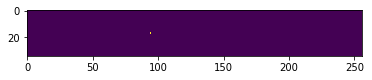

In [75]:
plt.imshow(dttube[:,:,135])

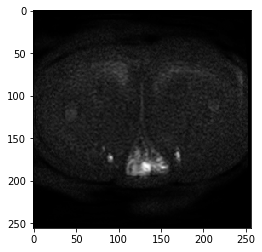

In [180]:
img=plt.imread('./datasets/rectal/'+coco.loadImgs(1)[0]['file_name'])
plt.imshow(img)